In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv


# 150 Bi-TCN LR

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 150 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features 
selected_features = np.array(feature_names)[sorted_idx]
num_features = len(selected_features)  # Get number of selected features

# Print the number of selected features
print(f"Number of features used for model training: {num_features}")

# Select corresponding columns from scaled dataset
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for Bi-TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define Bi-TCN Residual Block with Dilated Convolutions
def bi_residual_block(x, filters, dilation_rate):
    """Bidirectional TCN Residual Block"""
    # Forward Conv1D
    forward = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    forward = BatchNormalization()(forward)
    forward = ReLU()(forward)
    forward = Dropout(0.3)(forward)

    # Backward Conv1D (Reverse Input)
    backward = Lambda(lambda x: tf.reverse(x, axis=[1]))(x)  # Reverse time axis
    backward = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(backward)
    backward = BatchNormalization()(backward)
    backward = ReLU()(backward)
    backward = Dropout(0.3)(backward)
    backward = Lambda(lambda x: tf.reverse(x, axis=[1]))(backward)  # Reverse back

    # Merge Forward and Backward Paths
    merged = Add()([forward, backward])

    return Add()([x, merged])  # Residual Connection

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define Bi-TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # Bi-TCN Residual Blocks with Dilated Convolutions
        res_block1 = bi_residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = bi_residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = bi_residual_block(res_block2, filters=64, dilation_rate=4)

        flatten = Flatten()(res_block3)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

print("\nBest Model Architecture Summary:")
best_model.summary()

# Function to print clean model summary with renumbered layers
def print_renumbered_model_summary(model):
    print("\nBest Model Architecture Summary:")
    print(f"{'Layer Type':<25}{'Output Shape':<30}{'Param #':<15}")
    print("=" * 75)

    layer_counts = {}  # Dictionary to track the count of each layer type

    for layer in model.layers:
        layer_type = layer.__class__.__name__  # Get layer type
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else "N/A"
        param_count = layer.count_params() if hasattr(layer, 'count_params') else 0

        # Track counts and rename layer type
        if layer_type not in layer_counts:
            layer_counts[layer_type] = 1
        else:
            layer_counts[layer_type] += 1

        renamed_layer = f"{layer_type.lower()}_{layer_counts[layer_type]}"  # Format: conv1d_1, conv1d_2, etc.

        print(f"{renamed_layer:<25}{output_shape:<30}{param_count:<15}")

# Print renumbered model summary
print_renumbered_model_summary(best_model)
print("----------------------------------------------")

# Print Metrics
print(f"Number of features used for model training: {num_features}")
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


Number of features used for model training: 150


Running Cross-Validation: 100%|██████████| 2/2 [01:09<00:00, 34.56s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Best Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 150, 1)         │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 150, 64)        │            256 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 150, 64)        │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 150, 64)        │            256 │ conv1d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 150, 64)        │            256 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_7 (ReLU)            │ (None, 150, 64)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 150, 64)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 150, 64)        │              0 │ re_lu_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 150, 64)        │              0 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 150, 64)        │              0 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 150, 64)        │              0 │ dropout_7[0][0],       │
│                           │                        │                │ lambda_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 150, 64)        │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 150, 64)        │              0 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 150, 64)        │         12,352 │ lambda_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 150, 64)        │         12,352 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 150, 64)        │            256 │ conv1d_9[0][0]         │
│ (BatchNormalization) 

 Total params: 3,841,940 (14.66 MB)

 Trainable params: 1,280,390 (4.88 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2,560,782 (9.77 MB)


Best Model Architecture Summary:
Layer Type               Output Shape                  Param #        
inputlayer_1             N/A                           0              
lambda_1                 N/A                           0              
conv1d_1                 N/A                           256            
conv1d_2                 N/A                           256            
batchnormalization_1     N/A                           256            
batchnormalization_2     N/A                           256            
relu_1                   N/A                           0              
relu_2                   N/A                           0              
dropout_1                N/A                           0              
dropout_2                N/A                           0              
lambda_2                 N/A                           0              
add_1                    N/A                           0              
add_2                    N/A               

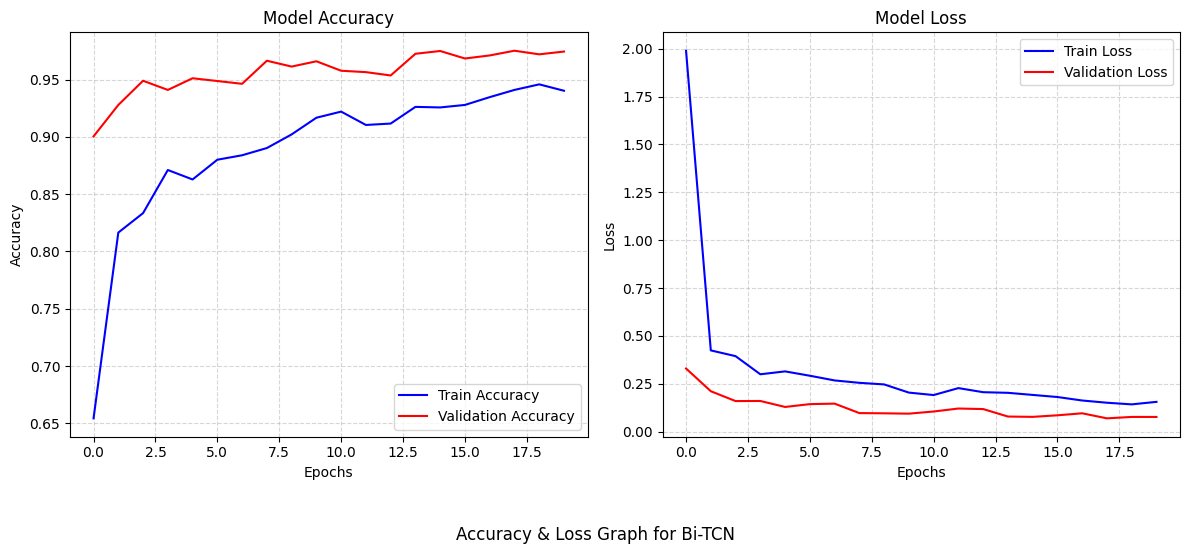

In [4]:
# Set white background
plt.style.use('default')

# Plot Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
# Add text below the graph
plt.figtext(0.5, -0.09, "Accuracy & Loss Graph for Bi-TCN", ha="center", fontsize=12)

plt.show()


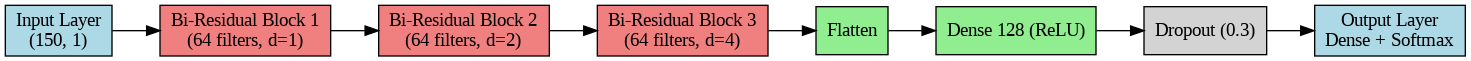

In [1]:
from graphviz import Digraph
from IPython.display import Image

def visualize_bi_tcn_model():
    dot = Digraph(format='png')
    dot.attr(rankdir='LR') 
    
    # Input Layer
    dot.node('Input', 'Input Layer\n(150, 1)', shape='box', style='filled', fillcolor='lightblue')
    
    # Bi-TCN Residual Blocks
    dot.node('RB1', 'Bi-Residual Block 1\n(64 filters, d=1)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB2', 'Bi-Residual Block 2\n(64 filters, d=2)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB3', 'Bi-Residual Block 3\n(64 filters, d=4)', shape='box', style='filled', fillcolor='lightcoral')
    
    # Fully Connected Layers
    dot.node('Flatten', 'Flatten', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense1', 'Dense 128 (ReLU)', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightgrey')
    dot.node('Output', 'Output Layer\nDense + Softmax', shape='box', style='filled', fillcolor='lightblue')
    
    # Connections
    dot.edge('Input', 'RB1')
    dot.edge('RB1', 'RB2')
    dot.edge('RB2', 'RB3')
    dot.edge('RB3', 'Flatten')
    dot.edge('Flatten', 'Dense1')
    dot.edge('Dense1', 'Dropout')
    dot.edge('Dropout', 'Output')
    
    return dot

# Render and visualize the model
model_diagram = visualize_bi_tcn_model()
model_diagram.render('bi_tcn_model', view=True)
model_diagram
# Render and save the model architecture as a PNG file
model_diagram = visualize_bi_tcn_model()
model_diagram.render('bi_tcn_model', format='png', cleanup=False)  # Save as PNG

# ✅ Display the saved image
Image(filename='bi_tcn_model.png')


# Number of features used for model training: 150
# Model Test Accuracy: 0.9714
# Precision: 0.9715
# Recall (Sensitivity): 0.9714
# Specificity: 0.9728
# F1-Score: 0.9713
# ROC AUC: 0.9989
# Training Time (Best Model): 38.83 seconds
# Inference Time: 1.55 seconds